---
title:  "Recommendation Basic 01"
excerpt: "Recommendation system using surprise library"

categories:
  - Machine-Learning
tags:
  - ML  
  - surprise  
  - Medium/susanli
  - Recommendation
last_modified_at: 2020-03-07T18:06:00-05:00
---

추천 시스템에서 유명한 library 는 surprise 이다. 워낙 유명하나, 개인적으로 한번 밖에 해본적이 없어서,  
기억이 가물거리는 관계로 남긴다.
> 1. CF, latent matrix 를 활용한다.  
> 2. [Medium susanLi](https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b)  
> 3. [SusanLi github](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb)
> 4. [나름 추천 잘하는 사람일것 같은 사람의 github](https://github.com/bigsnarfdude/guide-to-data-mining)
> 5. [Naber Lab Reseacher 초고수](http://sanghyukchun.github.io/31/)

In [1]:
import pandas as pd
import numpy as np

[surprise 공식문서 링크](https://surprise.readthedocs.io/en/stable/)

In [2]:
user = pd.read_csv('D:/★2020_ML_DL_Project/Alchemy/dataset/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
user.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('D:/★2020_ML_DL_Project/Alchemy/dataset/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']

==========================__Data 탐색 Start__=========================

In [3]:
print(user.shape,rating.shape)

(278857, 3) (1149779, 3)


In [4]:
user.head(3)

userID                         Location Age
0       2        stockton, california, usa  18
1       3  moscow, yukon territory, russia  \N
2       4        porto, v.n.gaia, portugal  17

In [5]:
rating.head(3)

userID        ISBN  bookRating
0  276726  0155061224           5
1  276727  0446520802           0
2  276729  052165615X           3

==========================__Data 탐색 End__=========================

In [6]:
df = pd.merge(user, rating, on='userID', how='inner') ## inner join 했지만, 딱히 줄어들거나, 변경된것은 없는 듯.
df.drop(['Location', 'Age'], axis=1, inplace=True)

In [7]:
print(df.shape)
df.head(3) ## 별차이 없네..그냥 rating 데이터 하나만 써도 될듯 1149779

(1149779, 3)


userID        ISBN  bookRating
0       2  0195153448           0
1       7   034542252           0
2       8  0002005018           5

In [8]:
df.columns.isnull()
## null 컬럼은 없는 것으로. 

array([False, False, False])

In [9]:
print('Dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::200000, :]) ## susan 씨는 200000 만단위로 끊어보는식으로 데이터를 탐색함

Dataset shape: (1149779, 3)
-Dataset examples-
         userID        ISBN  bookRating
0             2  0195153448           0
200000    48494  0871233428           0
400000    98391  0670032549          10
600000   147513  0470832525           5
800000   196502  0590431862           0
1000000  242157  0732275865           0


__본격 EDA__  
Rating Distribution

아래코드는 plotly 코드인데, jupyter lab 에서는 화면이 보이지 않는다. 찾아보니,  
**jupyter lab 용 extentsion 을 깔아야 한다.**  
그럼에도 불구하고 안될때가 있다. 원래 어떤 프로그램이든, 동작이 되는 case 는 1개이나, 안되는 이유는 수백가지이다.  
필자는 window10 에서, conda env 환경이었고, 이에 맞추어서 extentsion 을 깔았다.  
그리고, 엔코딩 에러가 나서, 윈도우 환경설정에서, UTF-8 을 활용한다는 체크박스를 표시했더니, 되었다.

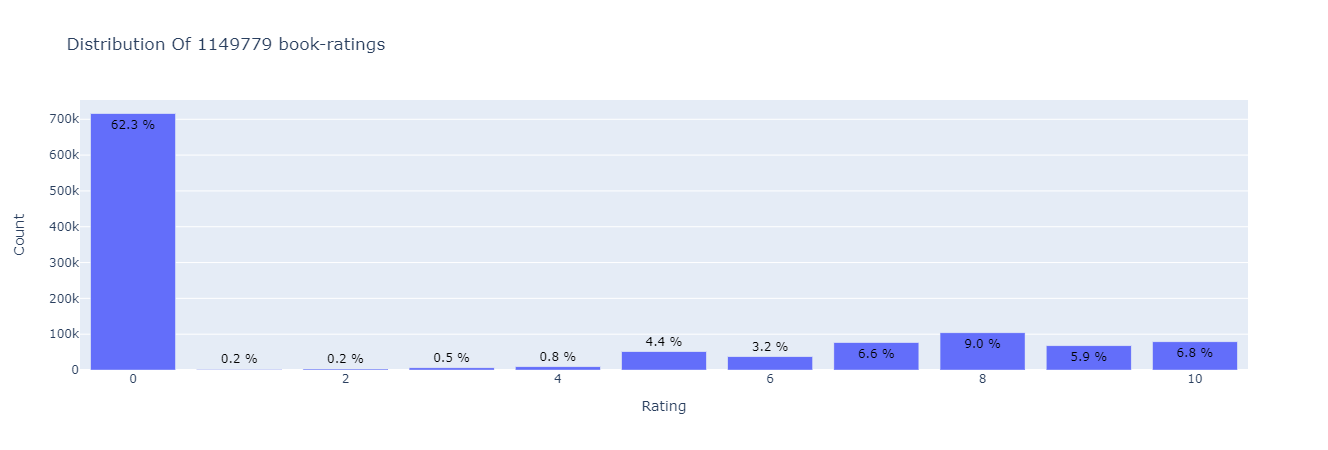

In [10]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['bookRating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

plotly 가 작동하지 않을때는 하기 코드를 활용하면 된다. 필자는 matplotlib 을 사용하기로 했다. with seaborn

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="white", context="talk")

In [12]:
data = df['bookRating'].value_counts().sort_index(ascending=False)
print(data)

10     78610
9      67541
8     103736
7      76457
6      36924
5      50974
4       8904
3       5996
2       2759
1       1770
0     716108
Name: bookRating, dtype: int64


Text(0, 0.5, 'Sequential')

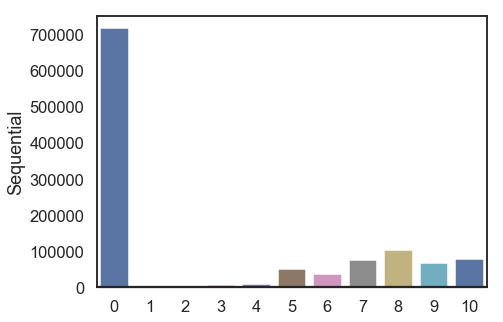

In [13]:
# Set up the matplotlib figure
f, ax1 = plt.subplots(1, 1, figsize=(7, 5), sharex=True)
sns.barplot(x=data.index, y=data.values, palette="deep", ax=ax1) ## deep, muted, pastel, bright, dark, and colorblind.
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Sequential")

In [14]:
(data/data.sum())*100

10     6.836966
9      5.874259
8      9.022256
7      6.649713
6      3.211400
5      4.433374
4      0.774410
3      0.521492
2      0.239959
1      0.153943
0     62.282230
Name: bookRating, dtype: float64

대략 62%에 달하는 user 들이 rating에 0 점을 부여했다. 이 0점은 과연 book 평점을 최악을 준걸까? 아니면, 평점 자체를 달지 않은걸까? 어떻게 봐야하나?

책별로, 평점이 가장 많이 달린걸 보자면...

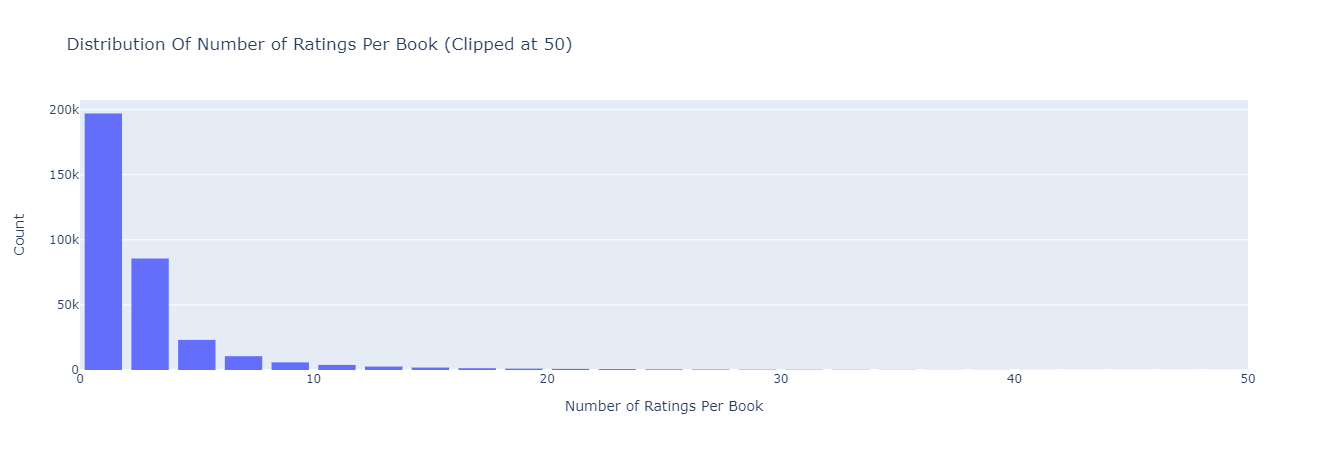

In [15]:
# Number of ratings per book
data = df.groupby('ISBN')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [16]:
df.groupby(by=['ISBN'],as_index=False)['bookRating'].count().sort_values('bookRating', ascending=False)[:10]

ISBN  bookRating
247408  0971880107        2502
47371   0316666343        1295
83359   0385504209         883
9637    0060928336         732
41007   0312195516         723
101670  044023722X         647
166705  0679781587         639
28153   0142001740         615
166434  067976402X         614
153620  0671027360         586

유저별로, 어떤 유저가 평점을 가자 많이 달았는지 보자면....

In [17]:
df.groupby(by=['userID'],as_index=False)['bookRating'].count().sort_values('bookRating', ascending=False)[:10]

userID  bookRating
4213     11676       13602
74815   198711        7550
58113   153662        6109
37356    98391        5891
13576    35859        5850
80185   212898        4785
105110  278418        4533
28884    76352        3367
42037   110973        3100
88584   235105        3067

11676 이 다독왕임을 알수있다.  
대부분의 이용자들은 5점 미만의 시청률을 기록했고, 가장 생산적인 이용자가 1만3602점을 주었지만 많은 시청률을 기록한 이용자는 극소수였다.  
위의 두 차트가 동일한 분포를 공유한다는 것을 눈치챘을 겁니다. 도서당 시청률 수와 사용자당 시청률 수는 기하급수적으로 감소한다.  
__데이터 세트의 치수를 줄이기 위해 등급이 거의 없는 도서와 평점이 거의 주지 않는 사용자들을 걸러낼 것이다.__

In [18]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings  ## 50보다 큰 ISBN 번호들만 남긴다. 
filter_books = filter_books[filter_books].index.tolist() ## 평점 50개 달린,(또는 그이상)되는 책들만, 리스트화 한다.

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))] ## 최소 충족요건을 만족한 data 들만, 추려서 들고온다.
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1149779, 3)
The new data frame shape:	(140516, 3)


In [19]:
df_new.head()

userID        ISBN  bookRating
394     243  0060915544          10
395     243  0060977493           7
397     243  0156006529           0
400     243  0316096199           0
401     243  0316601950           9

__진짜 Surprise library 사용하기__

In [21]:
from surprise import Reader
from surprise import Dataset
## Dataset 모듈에서, Reader class를 param으로 사용한다.
reader = Reader(rating_scale=(0, 9))
s_data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

===================**surprise의 기초상식 데이터 불러오기 Start**==================

In [23]:
## surprise 의 자체 내장 샘플데이터를 불러올 수도 있다.
sample_data = Dataset.load_builtin(name=u'ml-100k', prompt=True)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] 

 Y


Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to C:\Users\정진환/.surprise_data/ml-100k


In [57]:
print(type(sample_data))
ss = sample_data.build_full_trainset() ## surprise 는 특이하게 saple_data는 Object이고, 직접 데이터를 볼 수 는 없다. traintset class로 변환을 해줘야 한다.
## !! surprise 의 trainset class 로 return 해주는 거지, 혹시, k-fold 목적처럼, trainset, val_set,test_set 이렇게 구분해서 return 해주는게 아니라, 전체 데이터를 return 하는 것이다!!

<class 'surprise.dataset.DatasetAutoFolds'>


trainset class 로 변환된 이후, class 내 변수들을 활용해서, 데이터를 접근할 수 있다.  

In [45]:
print(ss.n_users,ss.n_items)
print(type(ss.ur)) ## ur,ir,n_users,n_items..등등 많은게 있다.

943 1682
<class 'collections.defaultdict'>


In [106]:
test_anti_set = ss.build_anti_testset() ## 이건 rui rating 점수가 없는 데이텟들에 대해서 return 해주고, rating점수가 원래 없던 녀석들이니, default로 global_mean 값을 넣어준다
test_test_set = ss.build_testset() ## testset 이 될수 없는 점수가 없는 데이터들을 걸러내고, test 셋을 만들어준다. 

test_anti_set+test_test_set 더하게 되면, ss 원데이터의 행 (user * item) 만큼의 숫자가 나오게 된다.

In [63]:
print(ss.global_mean)

3.52986


In [64]:
print(test_anti_set[0:5],"전체수량",len(test_anti_set))

[('196', '302', 3.52986), ('196', '377', 3.52986), ('196', '51', 3.52986), ('196', '346', 3.52986), ('196', '474', 3.52986)] 전체수량 1486126


reader 는 sclae를 관장한다. rating 의 점수 범위를 말한다.

이쯤되면, 꽤나 데이셋 구조가 궁금한데 내장데이터 말고 외부 데이터를 불러오는 모습을 통해서 대략 예측가능하다.  
df_new[['userID', 'ISBN', 'bookRating']] <- 이게 기본구조이면, surprise trainset class 구조도 동일하다. 내부에 이런 형태로 존재한다

===================**surprise의 기초상식 데이터 불러오기 End**==================

In [66]:
print(type(s_data),s_data)

<class 'surprise.dataset.DatasetAutoFolds'> <surprise.dataset.DatasetAutoFolds object at 0x0000022971B27160>


We use rmse as our accuracy metric for the predictions.

https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html 상세한 설명은 여기에

여기서부터는 surprise의 여러 알고리즘이 등장하는데, Susan Li 의 설명을 보고도 몰라서, 그냥 내가 하나하나 정리하면서, 올린다.

# Basic algorithms

**NormalPredictor**
- NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.  

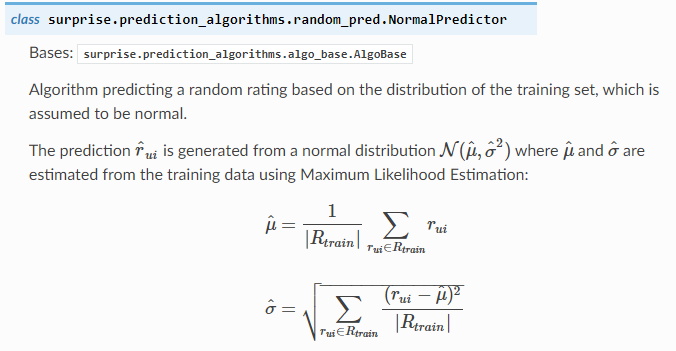

In [69]:
## surprise package 내에는 cross_validation 기능이 잘 되어있다.
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import model_selection
from surprise import accuracy

In [89]:
print(type(s_data))
s_data_01 = s_data.build_full_trainset() ## 이 형태로만 변해야 볼수 train_set 클래스에서 좀 데이터 상세를 접근할 수 있음. 

<class 'surprise.dataset.DatasetAutoFolds'>


In [85]:
print(s_data_01.n_users,s_data_01.n_items) ## (3247*2125,3) 형태의 2 tensor 인, matrix 구조 

3237 2125


In [71]:
print('Using NormalPredictor')
algo = NormalPredictor()

In [115]:
## train test 셋으로 나누어서 해보기
s_data_01_train, s_data_01_test = model_selection.train_test_split(data=s_data,test_size=0.2,random_state=42,shuffle=True)

In [116]:
print(s_data_01_train.n_users) ## s_data_01_train 는 자연스럽게 train_set class 로 변환된다.  / s_data_01_test 는 tuple 형태의 list 로 반환된다.
print(s_data_01_test[0:3])

3219
[(117111, '0446356832', 0.0), (201526, '067164257X', 0.0), (268032, '080411109X', 0.0)]


In [117]:
algo.fit(s_data_01_train)
sd01_result = algo.test(s_data_01_test) ## sckit-learin 으로 치면, predict_proba (surprise 에서, predict 는 특정 id , item 으로 rating 예측값을 볼때 사용한다.)

In [120]:
print(type(sd01_result[0]))
accuracy.rmse(sd01_result,verbose=True)

<class 'surprise.prediction_algorithms.predictions.Prediction'>
RMSE: 4.6978


4.69776110167572

In [125]:
## cross_validate 활용하기
cross_validate(algo, data=s_data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.6740  4.6745  4.7028  4.6836  4.6631  4.6796  0.0133  
Fit time          0.15    0.15    0.15    0.15    0.15    0.15    0.00    
Test time         0.12    0.32    0.12    0.12    0.12    0.16    0.08    


{'test_rmse': array([4.67396133, 4.67453189, 4.70283275, 4.68360735, 4.66311453]),
 'fit_time': (0.14561057090759277,
  0.15059709548950195,
  0.14860248565673828,
  0.14761614799499512,
  0.14860177040100098),
 'test_time': (0.11569046974182129,
  0.3201444149017334,
  0.11970329284667969,
  0.11768579483032227,
  0.11768579483032227)}

In [123]:
## cross_validate 수동으로 해보기
# define a cross-validation iterator
kf = model_selection.KFold(n_splits=5)

for trainset, testset in kf.split(s_data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 4.6618
RMSE: 4.6822
RMSE: 4.7042
RMSE: 4.6925
RMSE: 4.6409


다를 로직과 비교해 봐야 하나, 일단은 평범한 것으로 보인다.

**BaselineOnly**
- BasiclineOnly algorithm predicts the baseline estimate for given user and item.
- Baselines estimates configuration

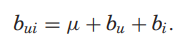

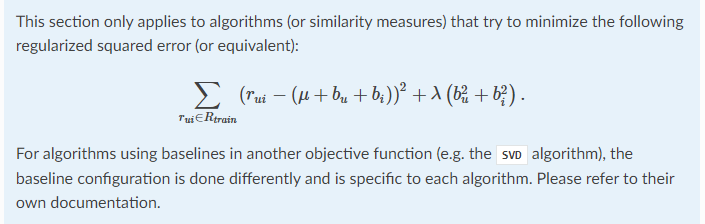

제일 위의 식이 Baselines 의 내용인데, bui = rui 즉 어떤 rating을 추정하는 텀. 맨 위가 Baseline 의 기본개념이다.  
뮤 는 전체 rating의 평균이고, bu 은 user의 bias, bi 는 item 의 bias이다. 이때, 핵심이 되는 bu, bi 를 구하는 Minimzie object 식이 밑에 그림이다.  
**Minimzie object 이 식의 찾는 과정에 fit(train) 과정이라 보면되는데 2가지 방식 'ALS' 랑 'SGD'방식이 있다.**

In [126]:
from surprise import BaselineOnly

In [129]:
print('Using ALS')
bsl_option = {'method': 'als','n_epochs': 10,'reg_u': 12,'reg_i': 5}
algo_01 = BaselineOnly(bsl_options=bsl_option)

Using ALS


상기 데이터 재활용 s_data_01_train, s_data_01_test = model_selection.train_test_split(data=s_data,test_size=0.2,random_state=42,shuffle=True)

In [130]:
algo_01.fit(s_data_01_train)
BS_ALS_result = algo_01.test(s_data_01_test) ## sckit-learin 으로 치면, predict_proba (surprise 에서, predict 는 특정 id , item 으로 rating 예측값을 볼때 사용한다.)

Estimating biases using als...


In [135]:
print(BS_ALS_result[0])
accuracy.rmse(BS_ALS_result,verbose=True)

user: 117111     item: 0446356832 r_ui = 0.00   est = 1.31   {'was_impossible': False}
RMSE: 3.3707


3.3706914692801067

In [138]:
## cross_validate 활용하기
algo_01_ALS_cross_rslt = cross_validate(algo_01, data=s_data, measures=['RMSE'], cv=5, verbose=False)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [140]:
algo_01_ALS_cross_rslt['test_rmse'].mean()

3.363798425105652

수동 cross_validation 은 생략했다. 일단, NormalPredictor 보다는 Baseline-ALS 가 효과가 좋아 보인다.

In [141]:
print('Using SGD')
bsl_option = {'method': 'sgd','n_epochs': 10,'reg_u': 12,'reg_i': 5}
algo_02 = BaselineOnly(bsl_options=bsl_option)

Using SGD


In [143]:
algo_02.fit(s_data_01_train)
BS_SGD_result = algo_02.test(s_data_01_test) ## sckit-learin 으로 치면, predict_proba (surprise 에서, predict 는 특정 id , item 으로 rating 예측값을 볼때 사용한다.)
print(BS_SGD_result[0])
accuracy.rmse(BS_SGD_result,verbose=True)

Estimating biases using sgd...
user: 117111     item: 0446356832 r_ui = 0.00   est = 1.27   {'was_impossible': False}
RMSE: 3.3710


3.3709595342543475

In [144]:
## cross_validate 활용하기
algo_02_SGD_cross_rslt = cross_validate(algo_02, data=s_data, measures=['RMSE'], cv=5, verbose=False)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...


In [145]:
algo_02_SGD_cross_rslt['test_rmse'].mean()

3.3617407419384273

수동 cross_validation 은 생략했다. 일단, NormalPredictor 보다는 Baseline-ALS 가 효과가 좋아 보인다.

# k-NN algorithms
**KNNBasic**  
- KNNBasic is a basic collaborative filtering algorithm.  

**KNNWithMeans**  
- KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.  

**KNNWithZScore**  
- KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.  

**KNNBaseline**  
- KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.

# Matrix Factorization-based algorithms
**SVD**
- SVD algorithm is equivalent to Probabilistic Matrix Factorization (http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf)  

**SVDpp**  
- The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.  

**NMF**  
- NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

# Slope One  
- Slope One is a straightforward implementation of the SlopeOne algorithm. (https://arxiv.org/abs/cs/0702144)

# Co-clustering
- Co-clustering is a collaborative filtering algorithm based on co-clustering (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf) We use rmse as our accuracy metric for the predictions.

In [ ]:
## 모든 객체와 라이브러니는 surprise package 안에 있는 것을 사용한다.
benchmark = [] ## 무사통과 알고리즘 : 
# Iterate over all algorithms  ## 에러나는 알고리즘 NMF(),
%time
for algorithm in [ SVD(), SVDpp(), SlopeOne(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    print(algorithm)
    results = cross_validate(algorithm, s_data, measures=['RMSE'], cv=3, verbose=False)     ## RMSE : 평균제곱근편차

In [ ]:
# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(tmp)

In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [ ]:
surprise_results